In [ ]:
# The monotonic WoE encoding requires `optimal_binning` library installed

In [5]:
!pip install optbinning
!pip install scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 kB 5.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 49.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 71.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-api 1.18.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 6.7.0 which is incompatible.
pymc3 3.11.5 requires

In [1]:
class statistical_pipeline:
    '''
    This pipeline expects the target variable to be binary. Please preprocess the target variable appropriately to meet this condition.
    '''
    def __init__(self, df, 
                target, 
                sample_size = -1, 
                random_state = 42,
                stratify = []):
        # Assuming the target variable contains binary data.
        # Initialize the dataframe we need to work on, and make the target variable appropriate for use.
        
        if sample_size == -1:
            self.df = df.copy()  
        else:
            if stratify:
                from sklearn.model_selection import train_test_split
                X_,_, y_, __  = train_test_split(df.drop(columns = target), df[target], train_size = sample_size, random_state = 42, stratify = df[stratify])
                df__ = pd.concat([X_, y_], axis = 1).copy().reset_index()
                df__ = df__.drop(columns = df__.columns[:2])
                self.df = df__.copy()
            else:
                self.df = df.sample(sample_size, random_state = random_state).reset_index().drop(columns = 'index').copy()
        self.df_orig = self.df.copy()
        
        self.target = target
        self.random_state = random_state
        self.df[target] = self.df[target].astype(float)
        self.domain_reduce_cols = []
        self.missing_values_cols_to_drop = []
        self.dummy_encoded_features = []
        self.woe_encoded_features = []
        self.cat_removed_features = []
        self.num_removed_features = []
        # Identify the categorical features in the dataset
        self.categorical_features = [col for col in self.df.columns if self.df.dtypes[col] == object]
        self.categorical_features = set(self.categorical_features)
        self.means = {}
        for col in self.df.columns:
            if col not in self.categorical_features:
                self.means[col] = self.df[col].mean()
        
    def autorun(self,
                predefined_variables_for_exclusion = [],
                time_period_datasets = [],
                cols_with_missing_values_threshold = 80,
                remove_high_cardinality_cols = True,
                high_cardinality_threshold = 40,
                psi_bins = 10,
                psi_thres = 0.2,
                missing_values_fillna_kind = 'special_value',
                cap_outliers = False,
                capping_numeric_cardinality_limit = 200,
                Cramers_V = True,
                monotonic_woe = True,
                numeric_woe = True,
                VIF = False,
                ANOVA = False, 
                MI = False,
                anova_thres = 0.05,
                mi_thres = 0.02,
                iv_thres = 0.02,
                iv_bins = 10,
                display_ivs = False,
                vif_thres = 7,
                display_mis = False,
                display_vifs = False,
                corr_thres = 0.5,
                cramers_v_thres = 0.3,
                dummy_thres = 3,
                RFE = True,
                rfe_n_features_to_select = None,
                test_size = 0.1,
                train_test_stratify = [],
                test_dataset = None,
                test_dataset_sample_size = -1,
                test_dataset_stratify = [],
                SMOTE = False,
                model = 'log_reg',
                reports_filepath = '',
                unique_id_cols = [],
                normalization = None):
        import matplotlib.pyplot as plt
        import seaborn as sns
        import pandas as pd
        import numpy as np
        from IPython.display import display
        import time
        from datetime import timedelta
        
        self.unique_id_cols = unique_id_cols
        self.monotonic_woe = monotonic_woe
        self.numeric_woe = numeric_woe
        self.missing_values_fillna_kind = missing_values_fillna_kind
        self.reduced_due_to_file = reports_filepath + 'Reduced due to.xlsx'
        self.univariate_bivariate_file = reports_filepath + 'Univariates and Bivariates report.xlsx'
        self.inter_feature_associations_file = reports_filepath + 'Inter-feature associations.xlsx'
        self.outliers_file = reports_filepath + 'Outliers.xlsx'
        self.results_file = reports_filepath + 'Results.xlsx'        
        
        start_whole = time.time()
        
        start = time.time()
        self.inconsistant_categorical_variable_reduction(time_period_datasets = time_period_datasets)
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        self.predefined_variable_exclusion(columns = predefined_variables_for_exclusion)
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        print('Creating Univariate Distribution Templates...')
        self.univariate_distribution_template_numeric()
        self.univariate_distribution_template_character()
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        self.remove_columns_with_missing_values(threshold = cols_with_missing_values_threshold)
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        if remove_high_cardinality_cols:
            start = time.time()
            self.remove_columns_with_high_cardinalities(threshold = high_cardinality_threshold)
            end = time.time()
            print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        self.remove_zero_var_cols(kind = 'before')
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        self.remove_datetime_cols()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        self.unstable_feature_reduction(time_period_datasets = time_period_datasets, bins = psi_bins, psi_thres = psi_thres)
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        self.fill_missing_values(kind = missing_values_fillna_kind)
        
        if cap_outliers: 
            start = time.time()
            self.cap_outliers(numeric_cardinality_lim = capping_numeric_cardinality_limit)
            end = time.time()
            print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        print('Creating Bivariates Report and Performing IV test...')
        self.Bivariates_report_and_IV_test(iv_thres = iv_thres, bins = iv_bins, display_ivs = display_ivs)
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        self.cramers_v_test(cramers_v_thres = cramers_v_thres)
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        self.correlation_test(corr_thres = corr_thres)
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        if monotonic_woe: 
            start = time.time()
            self.dummy_encode_categorical_vars(dummy_thres = dummy_thres)
            self.monotonic_woe_encode(numeric_woe = numeric_woe, dummy_thres = dummy_thres)
            end = time.time()
            print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        else:
            self.dummy_encode_categorical_vars(dummy_thres = dummy_thres)
            self.non_monotonic_woe_encode_categorical_vars(dummy_thres = dummy_thres)
        print('Info of current dataframe:\n')
        display(self.df.info())
        print()
        
        
        if ANOVA: 
            start = time.time()
            self.ANOVA_test(thres = anova_thres)
            end = time.time()
            print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        if VIF:
            start = time.time()
            self.VIF_test(thres = vif_thres, display_vifs = display_vifs)
            end = time.time()
            print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        if MI: 
            start = time.time()
            self.MI_test(thres = mi_thres, display_MIs = display_mis)
            end = time.time()
            print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        if RFE:
            start = time.time()
            self.recursive_feature_elimination(model = model, n_features_to_select = rfe_n_features_to_select)
            end = time.time()
            print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        print()
        print('Information of the current data:\n')
        display(self.df.info())
        print()
        print('Correlation matrix for the current dataset:\n')
        
        start = time.time()
        self.corr_chart()
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        print()
        
        start = time.time()
        print('Training the model...')
        self.split(test_size = test_size, stratify = train_test_stratify, test_dataset = test_dataset, test_dataset_sample_size = test_dataset_sample_size, test_dataset_stratify = test_dataset_stratify)
        self.train_model(kind = model, smote = SMOTE, normalization = normalization)
        end = time.time()
        print(f'Time taken to train: {str(timedelta(seconds=int(end - start)))}\n')
        
        start = time.time()
        print('Results on the test dataset:\n\n')
        print('Accuracy Score:\n')
        self.accuracy_score()
        print()
        print('Classification Report:\n')
        self.classification_report()
        print()
        print('Confusion Matrix:\n')
        self.confusion_matrix()
        print()
        print('K-S Table:\n')
        self.K_S_table(dataname = 'test')
        if not hasattr(self, 'test_df_orig'):
            self.test_df_orig = self.df_orig
        self.predicted_probability_report(df = self.X_test, orig_df = self.test_df_orig, unqiue_id_cols = unique_id_cols, dataname = 'test')
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        
        
        start = time.time()
        print('Results on the train dataset:\n\n')
        print('Accuracy Score:\n')
        y_proba = self.model.predict_proba(self.X_train)[:,1]
        y_pred = self.model.predict(self.X_train)
        self.accuracy_score(y_test = self.y_train, y_pred = y_pred)
        print()
        print('Classification Report:\n')
        self.classification_report(y_test = self.y_train, y_pred = y_pred)
        print()
        print('Confusion Matrix:\n')
        self.confusion_matrix(y_test = self.y_train, y_pred = y_pred)
        print()
        print('K-S Table:\n')
        self.K_S_table(X_test = self.X_train, y_test = self.y_train, y_proba = y_proba, dataname = 'train')
        self.predicted_probability_report(df = self.X_train, orig_df = self.df_orig, unqiue_id_cols = unique_id_cols, dataname = 'train')
        end = time.time()
        print(f'Time taken to run: {str(timedelta(seconds=int(end - start)))}\n')
        end_whole = time.time()
        print(f'Time taken to run the whole pipeline: {str(timedelta(seconds=int(end_whole - start_whole)))}\n')
    
    def add_to_excel(self, excelfile, sheet_name, df):
        import os
        if not os.path.isfile(excelfile):
            with pd.ExcelWriter(excelfile, engine='openpyxl') as writer:
                df.to_excel(writer, sheet_name=sheet_name)
        else:
            with pd.ExcelWriter(excelfile, engine='openpyxl', mode='a') as writer:
                df.to_excel(writer, sheet_name=sheet_name)
        
    def predefined_variable_exclusion(self, columns):
        self.domain_reduce(columns)
    
    def domain_reduce(self, columns):
        self.domain_reduce_cols.extend(columns)
        self.df.drop(columns = columns, inplace = True)
        print(f'These columns were manually reduced:\n{columns}\nCount:{len(columns)}\n')
        
        removed = pd.DataFrame(columns, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'Manual Reduction', df = removed)

    def inconsistant_categorical_variable_reduction(self, time_period_datasets = []):
        inconsistent_features = []
        for feature in self.df.columns:
            if feature in self.categorical_features:
                current_categories = set(self.df[feature].unique()) # This also unclide NaN values so if a feature has 3 categories and NaN values, len(self.df[feature].unique()) will be 4.
                for dataset in time_period_datasets:
                    new_categories = set(dataset[feature].unique())
                    if new_categories != current_categories:
                        inconsistent_features.append(feature)
                        break
        inconsistent_features = list(set(inconsistent_features))
        print(f'These categorical features were found to be inconsistent betweent the datasets:\n{inconsistent_features}\nCount:{len(inconsistent_features)}\n')
        self.df.drop(columns = inconsistent_features, inplace = True)
        removed = pd.DataFrame(inconsistent_features, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'Inconsistent categorical variables among different time periods', df = removed)
    
    def unstable_feature_reduction(self, time_period_datasets = [], bins = 10, psi_thres = 0.2):
        def calculate_psi_numeric(expected, actual, buckets):
            def scale_range (input, min, max):
                input += -(np.min(input))
                input /= np.max(input) / (max - min)
                input += min
                return input

            breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
            breakpoints = scale_range(breakpoints, np.min(expected), np.max(expected))

            expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
            actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)

            def sub_psi(e_perc, a_perc):
                if a_perc == 0:
                    a_perc = 0.0001
                if e_perc == 0:
                    e_perc = 0.0001
                value = (e_perc - a_perc) * np.log(e_perc / a_perc)
                return(value)

            psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

            return(psi_value)
        
        def calculate_psi_categorical(expected, actual):
            expected_counts = expected.fillna('missing').value_counts(normalize=True) # This handles missing values
            actual_counts = actual.fillna('missing').value_counts(normalize=True)

            def sub_psi(e_perc, a_perc):
                if a_perc == 0:
                    a_perc = 0.0001
                if e_perc == 0:
                    e_perc = 0.0001

                value = (e_perc - a_perc) * np.log(e_perc / a_perc)
                return(value)

            psi_value = np.sum(sub_psi(expected_counts[cat], actual_counts[cat]) for cat in expected_counts.index)

            return(psi_value)
        
        # Make sure that each dataset currently contains the same columns
        cols = self.df.columns
        for i in range(len(time_period_datasets)):
            time_period_datasets[i] = time_period_datasets[i][cols]
        
        unstable_features = []
        for feature in self.df.columns:
            for dataset in time_period_datasets:
                expected = self.df[feature]
                actual = dataset[feature]
                if feature in self.categorical_features:
                    psi = calculate_psi_categorical(expected, actual)
                    if psi > psi_thres:
                        unstable_features.append(feature)
                        break
                else:
                    expected = expected.dropna() # Handle missing values
                    actual = actual.dropna()
                    psi = calculate_psi_numeric(expected, actual, bins)
                    if psi > psi_thres:
                        unstable_features.append(feature)
                        break
        
        print(f'These feature were unstable across different time periods hence dropped:\n{unstable_features}\nCount:{len(unstable_features)}\n')
        
        removed = pd.DataFrame(unstable_features, columns = ['Variable'])
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'Unstable Features', df = removed)
            
    
    def univariate_distribution_template_numeric(self, df = None):
        if df is None:
            df = self.df.drop(columns = [column for column in self.df.columns if column in self.categorical_features])
        else:
            df = df.select_dtypes(exclude = ['object'])
        desc = df.describe(percentiles = [.01, .1, .25, .05, .5, .75, .9, .95, .99]).T
        desc['available_count'] = desc['count']
        desc.drop(columns = 'count', inplace = True)
        desc['Total'] = [df.shape[0] for _ in range(desc.shape[0])]
        desc['median'] = [df[desc.index[i]].median() for i in range(desc.shape[0])]
        desc['mode'] = [df[desc.index[i]].mode()[0] if len(df[desc.index[i]].mode()) else np.nan for i in range(desc.shape[0])]
        desc['missing_count'] = [df[desc.index[i]].isna().sum() for i in range(desc.shape[0])]
        desc['std'] = [df[desc.index[i]].std() for i in range(desc.shape[0])]
        desc['unique_values'] = [df[desc.index[i]].nunique() for i in range(desc.shape[0])]
                
        self.add_to_excel(excelfile = self.univariate_bivariate_file, sheet_name = 'Univariates (Numeric)', df = desc)
                
        return desc

    def univariate_distribution_template_character(self, df = None):
        if df is None:
            df = self.df[[column for column in self.df.columns if column in self.categorical_features]]
        else:
            df = df.select_dtypes(include = ['object'])
        result_df = pd.DataFrame(columns=['var_name', 'bin', 'count', 'percentage'])
        for column in df.columns:
            counts = df[column].value_counts().reset_index()            
            counts['percentage'] = counts[column] / len(df) * 100
            counts.columns = ['bin', 'count', 'percentage']
            counts['var_name'] = column
            result_df = pd.concat([result_df, counts], ignore_index=True)

        result_df = result_df[['var_name', 'bin', 'count', 'percentage']]
        self.add_to_excel(excelfile = self.univariate_bivariate_file, sheet_name = 'Univariates (Character)', df = result_df)
        return result_df
        
    #2 
    def remove_datetime_cols(self, df = None):
        if df is None:
            df = self.df
        datetime_cols = []
        for column in self.df.columns:
            if column in self.categorical_features:
                try:
                    pd.to_datetime(self.df[column])
                    datetime_cols.append(column)
                except ValueError:
                    continue
        df.drop(columns=datetime_cols, inplace = True)
        print(f'These columns were datetime hence dropped:\n{datetime_cols}\nCount:{len(datetime_cols)}\n')
        removed = pd.DataFrame(datetime_cols, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'Date Time', df = removed)
    
        
    def remove_columns_with_missing_values(self, threshold = 30, df = None):
        if df is None: df = self.df
        missing_percentages = df.isnull().mean() * 100
        self.missing_values_cols_to_drop = list(df.columns[list(missing_percentages > threshold)])
        df.drop(columns = self.missing_values_cols_to_drop, inplace = True)
        print(f'These columns had high amount of missing values hence dropped:\n{self.missing_values_cols_to_drop}\nCount:{len(self.missing_values_cols_to_drop)}\n')
        removed = pd.DataFrame(self.missing_values_cols_to_drop, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'High Missing Values', df = removed)
    #3
    def remove_columns_with_high_cardinalities(self, threshold = 40):
        categorical_cols = np.intersect1d(list(self.categorical_features), self.df.columns)
        columns_to_drop = []
        for col in categorical_cols:
            if threshold < 1 and threshold > 0:
                if (self.df[col].nunique() / len(self.df)) > threshold:
                    columns_to_drop.append(col)
            else:
                if self.df[col].nunique() > threshold:
                    columns_to_drop.append(col)
                
        self.df.drop(columns = columns_to_drop, inplace = True)
        print(f'These categorical columns were of high cardinality hence dropped:\n{columns_to_drop}\nCount:{len(columns_to_drop)}\n')
        removed = pd.DataFrame(columns_to_drop, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'High Cardinalities', df = removed)
        
    #4  
    def fill_missing_values(self, kind = 'mean'):
        for col in self.df.columns:
            # Handling of missing values for categorical vars is already done
            if col not in self.categorical_features:
                if kind == 'mean':
                    self.df[col].fillna(self.df[col].mean(), inplace = True)
                    self.means[col] = self.df[col].mean()
                elif kind == 'special_value':
                    self.df[col].fillna(-9999999, inplace = True)                    
            else:
                self.df[col].fillna('missing', inplace = True)
        
    def remove_zero_var_cols(self, kind = 'before'):
        variances = self.df.var()
        columns_to_drop = variances[variances == 0].index
        if kind == 'before': 
            self.cat_removed_features.extend(columns_to_drop)
        else:
            self.num_removed_features.extend(columns_to_drop)
        self.df.drop(columns = columns_to_drop, inplace = True)
        print(f'These columns had 0 variance hence dropped:\n{columns_to_drop}\nCount:{len(columns_to_drop)}\n')
        removed = pd.DataFrame(columns_to_drop, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'Zero Variance', df = removed)
        
    def cap_outliers(self, numeric_cardinality_lim = 200):
        def outliers_capping(feature,feature_name,dataset):
            # Identify 25th & 75th quartiles
            q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
            feat_iqr = q75 - q25

            feat_cut_off = feat_iqr * 1.5
            feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off

            outliers = [x for x in feature if (x < feat_lower and x != -9999999) or x > feat_upper]
            print(feature_name + ' outliers: {}'.format(len(outliers)))
            
            upper_idxes = dataset[(dataset[feature_name] > feat_upper)].index
            lower_idxes = dataset[(dataset[feature_name] < feat_lower) & (dataset[feature_name] != -9999999)].index
            
            upper_outliers = dataset.loc[upper_idxes].copy()
            lower_outliers = dataset.loc[lower_idxes].copy()
            
            # Cap outliers
            dataset[feature_name][upper_idxes] = feat_upper
            dataset[feature_name][lower_idxes] = feat_lower

            # Create DataFrame of outliers for this feature
            outliers_df = pd.concat([upper_outliers, lower_outliers])
            outliers_df['outlier_column'] = feature_name
            print('-' * 65)
            return outliers_df

        outlier_df_all = pd.DataFrame(columns = list(self.df.columns) + ['outlier_column'])
        for col in self.df:
            if col != self.target and col not in self.categorical_features and self.df[col].nunique() > numeric_cardinality_lim:
                outlier_df = outliers_capping(self.df[col],str(col),self.df)
                outlier_df_all = pd.concat([outlier_df_all, outlier_df])
        
        self.add_to_excel(excelfile = self.outliers_file, sheet_name = 'Outliers', df = outlier_df_all.replace(-9999999, np.nan))
    def corr_chart(self):
        import matplotlib.pyplot as plt
        import seaborn as sns
        f, ax = plt.subplots(figsize=(6, 5))
        mat = self.df.corr('spearman')
        mask = np.triu(np.ones_like(mat, dtype=bool))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(mat, mask=mask, cmap='brg', vmax=1, vmin = -1, center=0,# annot = True,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
        plt.tight_layout()
        plt.show()
    #5
    def correlation_test(self, corr_thres = 0.5):
        from sklearn.preprocessing import LabelEncoder
        # Separate features and target variable
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]

        # Encode categorical target variable if needed
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Make a list of redundant columns
        redundant_columns = []
        
        numerical_features = [col for col in X.columns if col not in self.categorical_features]
        
        df_dropped_features = pd.DataFrame(columns = ['feature1', 'feature2', 'dropped'])
        
        for i in range(len(numerical_features)):
            for j in range(i+1, len(numerical_features)):
                feature1 = numerical_features[i]
                feature2 = numerical_features[j]
                corr = X[feature1].corr(X[feature2])
                if abs(corr) > corr_thres:
                    iv1 = self.IV.loc[feature1][0]
                    iv2 = self.IV.loc[feature2][0]
                    if iv1 > iv2:
                        redundant_columns.append(feature2) 
                        df_dropped_features = df_dropped_features.append({
                            'feature1': feature1,
                            'feature2': feature2,
                            'dropped': feature2
                        }, ignore_index=True)
                    else:
                        redundant_columns.append(feature1)
                        df_dropped_features = df_dropped_features.append({
                            'feature1': feature1,
                            'feature2': feature2,
                            'dropped': feature1
                        }, ignore_index=True)
        
        redundant_columns = list(set(redundant_columns))
        print(f"correlation test removed these columns:\n{redundant_columns}\nCount:{len(redundant_columns)}\n")
        self.cat_removed_features.extend(redundant_columns)
        self.df.drop(columns = redundant_columns, inplace = True)
        removed = pd.DataFrame(redundant_columns, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'correlation_test', df = removed)
        self.add_to_excel(excelfile = self.inter_feature_associations_file, sheet_name = 'Features Removed in correlation_test', df = removed)
        
        # make and save correlation matrix
        numerical_df = X[numerical_features]
        corr_m = numerical_df.corr()
        self.add_to_excel(excelfile = self.inter_feature_associations_file, sheet_name = 'correlation matrix', df = corr_m)
        
        # save features compared and dropped matrix
        self.add_to_excel(excelfile = self.inter_feature_associations_file, sheet_name = 'Feature comparison in correlation_test', df = df_dropped_features)
        
    def cramers_v_test(self, cramers_v_thres = 0.5): 
        from sklearn.preprocessing import LabelEncoder
        from sklearn.feature_selection import chi2
        import scipy.stats

        # Separate features and target variable
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]

        # Encode categorical target variable if needed
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Make a list of redundant columns
        redundant_columns = []
        
        def get_cramers_v(x, y):
            confusion_matrix = pd.crosstab(x, y)
            chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        
        df_dropped_features = pd.DataFrame(columns = ['feature1', 'feature2', 'dropped'])
        
        categorical_features = np.intersect1d(list(self.categorical_features), self.df.columns)
        for i in range(len(categorical_features)):
            for j in range(i+1, len(categorical_features)):
                feature1 = categorical_features[i]
                feature2 = categorical_features[j]
                cramers_v = get_cramers_v(X[feature1], X[feature2])
                if cramers_v > cramers_v_thres:
                    iv1 = self.IV.loc[feature1][0]
                    iv2 = self.IV.loc[feature2][0]
                    if iv1 > iv2:
                        redundant_columns.append(feature2) 
                        df_dropped_features = df_dropped_features.append({
                            'feature1': feature1,
                            'feature2': feature2,
                            'dropped': feature2
                        }, ignore_index=True)
                    else:
                        redundant_columns.append(feature1)
                        df_dropped_features = df_dropped_features.append({
                            'feature1': feature1,
                            'feature2': feature2,
                            'dropped': feature1
                        }, ignore_index=True)
        redundant_columns = list(set(redundant_columns))
        print(f"cramer's v test removed these columns:\n{redundant_columns}\nCount:{len(redundant_columns)}\n")
        
        # Make cramers v matrix and save it
        categorical_df = X[categorical_features]
        cramers_v_matrix = pd.DataFrame({i : [get_cramers_v(categorical_df[i], categorical_df[j]) for j in categorical_df.columns] for i in categorical_df.columns})
        cramers_v_matrix = cramers_v_matrix.set_index(cramers_v_matrix.columns)
        self.add_to_excel(excelfile = self.inter_feature_associations_file, sheet_name = 'Cramers V Matrix', df = cramers_v_matrix)

        self.cat_removed_features.extend(redundant_columns)
        self.df.drop(columns = redundant_columns, inplace = True)
        removed = pd.DataFrame(redundant_columns, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'cramers_v_test', df = removed)
        self.add_to_excel(excelfile = self.inter_feature_associations_file, sheet_name = 'Features Removed in cramers_v_test', df = removed)
        # save features compared and dropped matrix
        self.add_to_excel(excelfile = self.inter_feature_associations_file, sheet_name = 'Feature comparison in cramers_v_test', df = df_dropped_features)
        
    def dummy_encode_categorical_vars(self, dummy_thres = 3):
        from sklearn.preprocessing import OneHotEncoder
        
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]
        
        self.dummy_encode_features = [col for col in X.columns if col in self.categorical_features and X[col].nunique() <= dummy_thres]
        self.dummy_encoder = OneHotEncoder(drop='first').fit(X[self.dummy_encode_features])
        
        dummy_encoded = self.dummy_encoder.transform(X[self.dummy_encode_features]).toarray()
        dummy_encoded = pd.DataFrame(dummy_encoded, columns=self.dummy_encoder.get_feature_names_out(self.dummy_encode_features))
        print(f"dummy encoded {self.dummy_encode_features} columns ")
        self.df = pd.concat([self.df.drop(columns = self.dummy_encode_features), dummy_encoded], axis = 1)
        self.categorical_features.update(dummy_encoded.columns)
        self.dummy_encoded_features = set(dummy_encoded.columns)
    
    def woe_encoder(self, df, woe_bins):
            import scorecardpy as sc
            return sc.woebin_ply(df, woe_bins)

    def non_monotonic_woe_encode_categorical_vars(self, dummy_thres = 3):
        import category_encoders as ce
        from sklearn.preprocessing import OneHotEncoder

        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]

        self.woe_encode_cat_features = [col for col in X.columns if col in self.categorical_features and X[col].nunique() > dummy_thres]

        self.woe_encoder = ce.WOEEncoder(cols=self.woe_encode_cat_features).fit(X[self.woe_encode_cat_features], y)

        woe_encoded = self.woe_encoder.transform(X[self.woe_encode_cat_features])

        self.df = pd.concat([self.df.drop(columns = self.woe_encode_cat_features),woe_encoded], axis = 1)
            
    def monotonic_woe_encode(self, numeric_woe = True, dummy_thres = 3):
        from optbinning import OptimalBinning
        X = self.df.drop(columns = self.target)
        # Identify your categorical and numeric features
        categorical_features = [col for col in X.columns if col in self.categorical_features and X[col].nunique() > dummy_thres]
        numeric_features = [col for col in X.columns if col not in self.categorical_features] if numeric_woe == True else []

        # Define a dictionary to hold the fitted OptimalBinning objects
        optb_objects = {}
                
        # Define a function to choose the trend that maximizes IV
        def choose_best_trend(feature, dtype):
            x = self.df[feature]
            y = self.df[self.target]
            
            # Define and fit the binning object with 'ascending' trend
            optb_asc = OptimalBinning(name=feature, dtype=dtype, solver="cp", 
                                      prebinning_method='cart', monotonic_trend='ascending', special_codes=[-9999999] if self.missing_values_fillna_kind == 'special_value' else None)
            optb_asc.fit(x, y)
            
            asc_table = optb_asc.binning_table.build()
            # Calculate the IV for 'ascending'
            iv_asc = asc_table.loc[:, "IV"].sum()

            # Define and fit the binning object with 'descending' trend
            optb_desc = OptimalBinning(name=feature, dtype=dtype, solver="cp", 
                                       prebinning_method='cart', monotonic_trend='descending', special_codes=[-9999999] if self.missing_values_fillna_kind == 'special_value' else None)
            optb_desc.fit(x, y)
            
            desc_table = optb_desc.binning_table.build()
            # Calculate the IV for 'descending'
            iv_desc = desc_table.loc[:, "IV"].sum()

            # Choose the trend that gives higher IV
            if iv_asc > iv_desc:
                return optb_asc
            else:
                return optb_desc

        # Loop over numeric features
        for feature in numeric_features:
            optb_objects[feature] = choose_best_trend(feature, "numerical")

            # Add the WoE transformed column to the dataframe
            self.df[feature] = optb_objects[feature].transform(self.df[feature], metric="woe")

        # Loop over categorical features
        for feature in categorical_features:
            optb_objects[feature] = choose_best_trend(feature, "categorical")

            # Add the WoE transformed column to the dataframe
            self.df[feature] = optb_objects[feature].transform(self.df[feature], metric="woe")
        
        self.woe_encode_cat_features = categorical_features
        self.woe_encode_num_features = numeric_features
        self.optb_objects = optb_objects
    
    def Bivariates_report_and_IV_test(self, iv_thres = 0.02, bins = 10, display_ivs = False):
        def iv_woe(data, target, bins=10, show_woe=False):
            newDF,woeDF = pd.DataFrame(), pd.DataFrame()
            cols = data.columns
            for ivars in cols[~cols.isin([target])]:
                if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
                    special_value = -9999999
                    data[ivars] = data[ivars].replace(special_value, np.nan)
                    binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
                    binned_x = binned_x.cat.add_categories([special_value])
                    binned_x.fillna(special_value, inplace=True)
                    d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
                    data[ivars] = data[ivars].replace(np.nan, special_value)
                else:
                    d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
                d0 = d0.astype({"x": str})
                d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
                d.columns = ['bin', 'total', 'bad']
                d['bad_rate'] = (d['bad'] + 0.5) / d['bad'].sum()
                d['good'] = d['total'] - d['bad']
                d['good_rate'] = (d['good'] + 0.5) / d['good'].sum()
                d['WoE'] = np.log(d['good_rate']/d['bad_rate'])
                d['IV_bin'] = d['WoE'] * (d['good_rate']-d['bad_rate'])
                d.insert(loc=0, column='Variable', value=ivars)
                temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV_bin'].sum()]}, columns = ["Variable", "IV"])
                newDF=pd.concat([newDF,temp], axis=0)
                woeDF=pd.concat([woeDF,d], axis=0)

                #Show WOE Table
                if show_woe == True:
                    display(d)
            return newDF, woeDF

        IV, IV_extended = iv_woe(self.df, self.target, bins = bins)
        IV.set_index('Variable', inplace = True)
        IV_extended['IV_total'] = IV_extended['Variable'].apply(lambda x: IV.loc[x])
        IV_extended.set_index('Variable', inplace = True)
        self.add_to_excel(excelfile = self.univariate_bivariate_file, sheet_name = 'Bivariates', df = IV_extended.replace('-9999999', 'NaN'))
        self.add_to_excel(excelfile = self.univariate_bivariate_file, sheet_name = 'IVs', df = IV)
        if display_ivs:
            display(IV)
        redundant_columns = []
        self.IV = IV
        for col in self.df.drop(columns = self.target).columns:
            if IV.loc[col][0] < iv_thres:
                redundant_columns.append(col)
            
        print(f'IV test removed these columns:\n{redundant_columns}\nCount: {len(redundant_columns)}\n')
        self.df.drop(columns = redundant_columns, inplace = True)
        removed = pd.DataFrame(redundant_columns, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'IV_test', df = removed)
    
    def ANOVA_test(self, thres = 0.05):
        from sklearn.preprocessing import LabelEncoder
        from sklearn.feature_selection import f_classif
        # Separate features and target variable
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]

        # Encode categorical target variable if needed
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Make a list of redundant columns
        redundant_columns = []
        
        for i, feature in enumerate(X.columns):
            f_stat, p_val = f_classif(X[feature].values.reshape(-1, 1), y)
            if p_val >= thres:
                redundant_columns.append(feature)
        print(f'ANOVA test removed these columns:\n{redundant_columns}\nCount: {len(redundant_columns)}\n')
        self.df.drop(columns = redundant_columns, inplace = True)
        removed = pd.DataFrame(redundant_columns, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'ANOVA_test', df = removed)
        
    def MI_test(self, thres = 0.02, display_MIs = False):
        from sklearn.preprocessing import LabelEncoder
        from sklearn.feature_selection import f_classif, mutual_info_classif
        # Separate features and target variable
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]

        # Encode categorical target variable if needed
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Make a list of redundant columns
        redundant_columns = []
        
        scores = mutual_info_classif(X, y)
        for i, score in enumerate(scores):
            scores[i] = "{:.4f}".format(score)
        MI = pd.DataFrame()
        MI["Variable"] = X.columns
        MI["MI"] = [scores[i] for i in range(X.shape[1])]
        MI.set_index('Variable', inplace = True)
        if display_MIs:
            print('MIs of each variable:\n')
            display(MI)
            print()
        for i, feature in enumerate(X.columns):
            if scores[i] < thres:
                redundant_columns.append(feature)
        print(f'mutual info test removed these columns:\n{redundant_columns}\nCount: {len(redundant_columns)}\n')
        self.df.drop(columns = redundant_columns, inplace = True)
        removed = pd.DataFrame(redundant_columns, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'MI_test', df = removed)
        
    def VIF_test(self, thres = 9, display_vifs = False):
        from sklearn.preprocessing import LabelEncoder
        from sklearn.feature_selection import f_classif, mutual_info_classif
        # Separate features and target variable
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]

        # Encode categorical target variable if needed
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Make a list of redundant columns
        redundant_columns = []
        
        import statsmodels.api as sm
        from statsmodels.stats.outliers_influence import variance_inflation_factor

        # Add a constant term for the intercept
        X_c = sm.add_constant(X)
        scores = [variance_inflation_factor(X_c.values, i) for i in range(X_c.shape[1])]
        # Calculate the VIF for each predictor variable
        vif = pd.DataFrame()
        vif["Variable"] = X_c.columns
        vif["VIF"] = [variance_inflation_factor(X_c.values, i) for i in range(X_c.shape[1])]
        vif.set_index('Variable', inplace = True)
        const_col = list(set(X_c.columns) - set(X.columns))
        if const_col: vif.drop(const_col[0], inplace = True)
        if display_vifs:
            print('VIFs of each variable:\n')
            display(vif)
            print()
        for i, feature in enumerate(X_c.columns):
            if feature != 'const' and vif.loc[feature]['VIF'] > thres:
                redundant_columns.append(feature)
        print(f'VIF test removed these columns:\n{redundant_columns}\nCount: {len(redundant_columns)}\n')
        self.num_removed_features.extend(redundant_columns)
        self.df.drop(columns = redundant_columns, inplace = True)
        removed = pd.DataFrame(redundant_columns, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'VIF_test', df = removed)
        
    def recursive_feature_elimination(self, model = 'log_reg', n_features_to_select = None):
        X = self.df.drop(columns = self.target)
        y = self.df[self.target]
        from mlxtend.feature_selection import SequentialFeatureSelector as SFS
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression()
        
        if n_features_to_select is None:
            n_features_to_select = 'best'
        else:
            n_features_to_select = min(n_features_to_select, X.shape[1])
        sfs1 = SFS(estimator, 
                   k_features=n_features_to_select, 
                   forward=True, 
                   floating=False, 
                   verbose=2,
                   scoring='accuracy',
                   cv=0,
                   n_jobs = -1)
        
        sfs1 = sfs1.fit(X, y)
        n_features_selected = max(sfs1.subsets_.keys())
        selected_features = list(sfs1.subsets_[n_features_selected]['feature_names']) + [self.target]
        removed_features = list(set(self.df.columns) - set(selected_features))
        print(f'Recursive feature elimination removed these columns:\n{removed_features}\nCount: {len(removed_features)}\n')
        self.df = self.df[selected_features]
        removed = pd.DataFrame(removed_features, columns = ['Variable'])
        
        self.add_to_excel(excelfile = self.reduced_due_to_file, sheet_name = 'recursive_feature_elimination', df = removed)
        
    def split(self, test_size = 0.1, stratify = [], test_dataset = None, test_dataset_sample_size = -1, test_dataset_stratify = []):
        if test_dataset is None:
            from sklearn.model_selection import train_test_split
            self.X = self.df.drop(columns = self.target)
            self.y = self.df[self.target]
            if not stratify: stratify = self.target
            self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(self.X,
                                                                                 self.y,
                                                                                 test_size=test_size,
                                                                                 stratify = self.df[stratify],
                                                                                 random_state = self.random_state)
            return self.X_train,self.X_test,self.y_train,self.y_test
        else:
            test_df = None
            
            # Sampling of test data if required
            if test_dataset_sample_size == -1:
                test_df = test_dataset.copy()  
            else:
                if test_dataset_stratify:
                    from sklearn.model_selection import train_test_split
                    X_,_, y_, __  = train_test_split(test_dataset.drop(columns = self.target), test_dataset[self.target], train_size = test_dataset_sample_size, random_state = self.random_state, stratify = test_dataset[test_dataset_stratify])
                    df__ = pd.concat([X_, y_], axis = 1).copy().reset_index()
                    df__ = df__.drop(columns = df__.columns[:2])
                    test_df = df__.copy()
                else:
                    test_df = test_dataset.sample(test_dataset_sample_size, random_state = self.random_state).reset_index().drop(columns = 'index').copy()
            self.test_df_orig = test_df.copy()
            
            # Preprocess the test data to pass it to the model
            if self.missing_values_cols_to_drop: test_df.drop(columns = self.missing_values_cols_to_drop, inplace = True)
            for col in test_df.columns: 
                # Handle missing values in categorical labels beforehand, as they do have a meaning.
                if test_df.dtypes[col] == object:
                    test_df[col].fillna('missing', inplace = True)
                else:
                    if self.missing_values_fillna_kind == 'mean':
                        test_df[col].fillna(self.means[col], inplace = True)
                    elif self.missing_values_fillna_kind == 'special_value':
                        test_df[col].fillna(-9999999, inplace = True)
                        
            # encode the categorical features
            dummy_encoded = self.dummy_encoder.transform(test_df[self.dummy_encode_features]).toarray()
            dummy_encoded = pd.DataFrame(dummy_encoded, columns=self.dummy_encoder.get_feature_names_out(self.dummy_encode_features))

            if not self.monotonic_woe:
                woe_encoded = self.woe_encoder.transform(test_df[self.woe_encode_cat_features])
                test_df = pd.concat([test_df.drop(columns = self.dummy_encode_features + self.woe_encode_cat_features), dummy_encoded, woe_encoded], axis = 1)

            else:
                for feature in self.woe_encode_cat_features:
                    test_df[feature] = self.optb_objects[feature].transform(test_df[feature], metric = 'woe')
                for feature in self.woe_encode_num_features:
                    test_df[feature] = self.optb_objects[feature].transform(test_df[feature], metric = 'woe')
                test_df = pd.concat([test_df.drop(columns = self.dummy_encode_features), dummy_encoded], axis = 1)
    
            test_df = test_df[self.df.columns]
            
            self.X_train = self.df.drop(columns = self.target)
            self.y_train = self.df[self.target]
            self.X_test = test_df.drop(columns = self.target)
            self.y_test = test_df[self.target]
            self.X = pd.concat([self.X_train, self.X_test])
            self.y = pd.concat([self.y_train, self.y_test])
            
    # 15
    def train_model(self, kind = 'log_reg', smote = True, normalize = None, normalization = None):
        from sklearn.model_selection import RandomizedSearchCV
        from sklearn.metrics import make_scorer
        from scipy.stats import ks_2samp
        from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
        from imblearn.over_sampling import SMOTENC, SMOTE
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
        from sklearn.linear_model import LogisticRegression
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.metrics import f1_score
        from xgboost import XGBClassifier
        from sklearn.ensemble import RandomForestClassifier
        from catboost import CatBoostClassifier
        from lightgbm import LGBMClassifier
        
        def ks_statistic(y_true, y_probas):
                return ks_2samp(y_probas[y_true == 1], y_probas[y_true == 0]).statistic

        ks_scorer = make_scorer(ks_statistic, needs_proba=True)
        categorical_column_indices = [self.X.columns.get_loc(feature) for feature in np.intersect1d(list(self.categorical_features), self.X.columns)]
#         print(categorical_column_indices, len(self.X.columns))
#         print(np.intersect1d(list(self.categorical_features), self.X.columns)
        models = {
            'log_reg': LogisticRegression(),
            'knn': KNeighborsClassifier(),
            'rfc': RandomForestClassifier(),
            'xgb': XGBClassifier(random_state = 42),
            'cat': CatBoostClassifier(verbose = 0),
            'lgbm': LGBMClassifier()
        }
        
        model_params = {
            
            'log_reg': {
                "penalty": ['l2'],
                'l1_ratio': [0,0.2,0.4,0.5,0.6,0.8,1],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'class_weight': ['balanced',None],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            },
            
            'knn': {
                'n_neighbors': [i for i in range(1, 100)]
            },
            
            'rfc':{
                'max_features' : ['auto', 'sqrt', 'log2'],
                'random_state' : [42],
                'class_weight' : ['balanced','balanced_subsample'],
                'criterion' : ['gini', 'entropy'],
                'bootstrap' : [True,False],
                'min_samples_leaf': [5,10,20],
                'max_depth' : [3,6,9]
            },
            
            'xgb':{
                'eta' : [0.1,0.01,0.001],  # Learning rate
                'eval_metric': ['logloss'],
                'max_depth' : [3,6,9],
                'lambda' : [1,1.5,2],      # L2 regularization (higher values make model more conservative)
                'alpha' : [0,0.5,1]
            },
            
            'cat':{
                'eval_metric': ['F1'],
                'iterations': [100,500,1000],
                'learning_rate' : [0.1,0.01,0.001],
                'random_seed' : [42],
                'auto_class_weights' : ['Balanced','SqrtBalanced']
            },
            
            'lgbm':{
                'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Shrinkage for each boosting step
                'n_estimators': [50, 100, 150],  # Number of boosting iterations
                'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances for boosting
                'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns for each boosting round
                'min_child_weight': [0.001, 0.01, 0.1, 1],  # Minimum sum of instance weight (hessian) needed in a child (leaf)
                'max_depth': [3,5,8,10],  # Maximum tree depth for base learners
                'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # L2 regularization term on weights
                'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # L1 regularization term on weights
            }
        }
        
        normalize_transformers = {
            None: FunctionTransformer(func=lambda x: x),
            'min-max': MinMaxScaler(),
            'z-score': StandardScaler()
        }
        
        rnd_model_ = RandomizedSearchCV(models[kind], model_params[kind], n_iter=4, scoring = 'f1')
        
        # SMOTE is applied only on training data in the pipeline, not on validation data which will be split when fitting the pipeline.
        imb_pipe = imbalanced_make_pipeline(SMOTENC(categorical_features = categorical_column_indices, random_state = self.random_state) if categorical_column_indices else SMOTE(random_state = self.random_state), rnd_model_)
        
        pipe = Pipeline([
            ('normalize_transformer', normalize_transformers[normalization]), 
            ('classifier', imb_pipe if smote else rnd_model_)
        ])
        
        pipe.fit(self.X_train, self.y_train)
        
        best_model = rnd_model_.best_estimator_
        print(f'Best params for RndSearchCV:\n{rnd_model_.best_params_}')
        
        eval_pipe = Pipeline([
            ('normalize_transformer', normalize_transformers[normalization]), 
            ('classifier', best_model)
        ])
        
        eval_pipe.fit(self.X_train, self.y_train)
        
        self.model = eval_pipe
            
        self.y_proba = self.model.predict_proba(self.X_test)[:,1]
        self.y_pred = self.model.predict(self.X_test)
        
        
    # 16
    def accuracy_score(self, y_test = None, y_pred = None):
        if y_test is None:
            y_test = self.y_test
        if y_pred is None:
            y_pred = self.y_pred
        from sklearn.metrics import accuracy_score
        print(accuracy_score(y_test,y_pred))
        return accuracy_score(y_test,y_pred)
    
    # 17
    def classification_report(self, y_test = None, y_pred = None):
        if y_test is None:
            y_test = self.y_test
        if y_pred is None:
            y_pred = self.y_pred
        from sklearn.metrics import classification_report
        print(classification_report(y_test, y_pred))
        
    # 18
    def confusion_matrix(self, y_test = None, y_pred = None):
        if y_test is None:
            y_test = self.y_test
        if y_pred is None:
            y_pred = self.y_pred
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        import seaborn as sns
        f, ax = plt.subplots(figsize=(3, 2))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = 'coolwarm', fmt='d')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()
        
    # 19
    def K_S_table(self, X_test = None, y_test = None, y_proba = None, dataname = 'test'):
        if X_test is None:
            X_test = self.X_test
        if y_test is None:
            y_test = self.y_test
        if y_proba is None:
            y_proba = self.y_proba
        df = pd.DataFrame(X_test).copy()
        df['predicted_probability'] = y_proba
        df['GT'] = np.array(y_test) #Ground Truth
        def k_s_statistics_gain_lift(data,predicted_probability,ground_truth,response_name='Risk'):
            data= data.sort_values(by=predicted_probability, ascending=False)
            #print(data)
            #Cut deciles based on the predicted probabilities
            eps = np.random.uniform(low=-0.0001, high=0.0001, size=len(data))
            data[predicted_probability] += eps
#             data['decile_group'] = pd.qcut((data[predicted_probability].rank(method = 'first')), q=10)
            data['decile_group'] = pd.qcut((data[predicted_probability]), q=10)
            #Create success and failure response column
            KS_data = data.groupby('decile_group').agg( #Group by Deciles of Predicted Probabilties
                    [
                        'count', #The total number of customers(data points) in the decile
                        'sum', #The total number of bad customers(Risk=1)
                    ]
                    )[ground_truth].sort_index(ascending=False)
            KS_data.columns = ['Total count','Number of '+response_name]
            KS_data['Number of '+'Non-'+response_name]=KS_data['Total count']-KS_data['Number of '+response_name]
            KS_data[response_name+'_Rate'+'%'] = (KS_data['Number of '+response_name] / KS_data['Total count']).apply(lambda x:round(100*x,2))
            KS_data['Percent of '+response_name+'%'] = (KS_data['Number of '+response_name]/KS_data['Number of '+response_name].sum()).apply(lambda x:round(100*x,2))
            KS_data['Percent of '+'Non-'+response_name+'%'] = (KS_data['Number of '+'Non-'+response_name]/KS_data['Number of '+'Non-'+response_name].sum()).apply(lambda x:round(100*x,2))
            KS_data['Cum % ' + response_name] = np.round((KS_data['Number of '+response_name] / KS_data['Number of '+response_name].sum()).cumsum(), 4) * 100
            KS_data['Cum % ' + 'Non-' + response_name] = np.round((KS_data['Number of '+ 'Non-'+response_name] / KS_data['Number of '+ 'Non-'+response_name].sum()).cumsum(), 4) * 100
            KS_data['ks_stats'] = np.round(((KS_data['Number of '+response_name] / KS_data['Number of '+response_name].sum()).cumsum() -(KS_data['Number of '+'Non-'+response_name] / KS_data['Number of '+'Non-'+response_name].sum()).cumsum()), 4) * 100
            KS_data['max_ks'] = KS_data['ks_stats'].apply(lambda x: '*****' if x == KS_data['ks_stats'].max() else '')    
            return KS_data
        df = k_s_statistics_gain_lift(df, 'predicted_probability', 'GT', response_name = 'bad')
        colormap = 'coolwarm'  # Choose the desired colormap
        df_styled = df.style.background_gradient(cmap=colormap, subset=['ks_stats'])
        display(df_styled)
        self.add_to_excel(excelfile = self.results_file, sheet_name = dataname + '-ks-stats', df = df_styled)
    
    def predicted_probability_report(self, df, orig_df, unqiue_id_cols = [], dataname = ''):
        X = df
        if self.target in df.columns:
            X = df.drop(columns = self.target)
            y = df[self.target]
        y_pred = self.model.predict(X)
        y_pred_proba = self.model.predict_proba(X)[:,1]
        y_pred_proba = pd.DataFrame(y_pred_proba, index = X.index, columns = ['predicted_probability'])
        unique_id_df = orig_df[unqiue_id_cols].loc[X.index]
        report_df = pd.concat([unique_id_df, X, y_pred_proba], axis = 1)
        self.add_to_excel(excelfile = self.results_file, sheet_name = dataname + '-predicted probability report', df = report_df.replace(-9999999, np.nan))
    
    def predict(self, test_df, dataname = '', reports_filepath = ''):
        import time
        from datetime import timedelta
        start = time.time()
        
        test_df = test_df.copy()
        # if the given data is a single row, it may be a series, so make it an appropriate dataframe
        if type(test_df) == pd.core.series.Series:
            test_df = pd.DataFrame(test_df).T
        test_df_orig = test_df.copy()
        
        if self.missing_values_cols_to_drop: test_df.drop(columns = self.missing_values_cols_to_drop, inplace = True)
        for col in test_df.columns: 
            # Handle missing values in categorical labels beforehand, as they do have a meaning.
            if test_df.dtypes[col] == object:
                test_df[col].fillna('missing', inplace = True)
            else:
                if self.missing_values_fillna_kind == 'mean':
                    test_df[col].fillna(self.means[col], inplace = True)
                elif self.missing_values_fillna_kind == 'special_value':
                    test_df[col].fillna(-9999999, inplace = True)
        # encode the categorical features
        dummy_encoded = self.dummy_encoder.transform(test_df[self.dummy_encode_features]).toarray()
        dummy_encoded = pd.DataFrame(dummy_encoded, columns=self.dummy_encoder.get_feature_names_out(self.dummy_encode_features))
        
        if not self.monotonic_woe:
            woe_encoded = self.woe_encoder.transform(test_df[self.woe_encode_cat_features])
            test_df = pd.concat([test_df.drop(columns = self.dummy_encode_features + self.woe_encode_cat_features), dummy_encoded, woe_encoded], axis = 1)
        
        else:
            for feature in self.woe_encode_cat_features:
                test_df[feature] = self.optb_objects[feature].transform(test_df[feature], metric = 'woe')
            for feature in self.woe_encode_num_features:
                test_df[feature] = self.optb_objects[feature].transform(test_df[feature], metric = 'woe')
                
            test_df = pd.concat([test_df.drop(columns = self.dummy_encode_features), dummy_encoded], axis = 1)
        
        
        test_df = test_df[self.df.columns]
        X = test_df.drop(columns = self.target)
        y = test_df[self.target]
        
        y_pred = self.model.predict(X)
        
        y_pred_proba = self.model.predict_proba(X)[:,1]
        
        print('Accuracy Score:\n')
        self.accuracy_score(y_test = y, y_pred = y_pred)
        print()
        print('Classification Report:\n')
        self.classification_report(y_test = y, y_pred = y_pred)
        print()
        print('Confusion Matrix:\n')
        self.confusion_matrix(y_test = y, y_pred = y_pred)
        print()
        print('K-S Table:\n')
        self.K_S_table(X_test = X, y_test = y, y_proba = y_pred_proba, dataname = dataname)
        self.predicted_probability_report(X, test_df_orig, unqiue_id_cols = self.unique_id_cols, dataname = dataname)
        end = time.time()
        print(f'Time taken to test: {str(timedelta(seconds=int(end - start)))}\n')
        return y_pred, y_pred_proba
    

In [2]:
# Importing necessary pipelines
import numpy as np 
import pandas as pd
from IPython.display import display
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)  # Set the maximum number of rows to display (change to your desired limit)
pd.set_option('display.max_columns', 100)

In [2]:
# load your data here and make sure the target variable is binary
loan_data = '/kaggle/input/lending-club-loan-data-csv/loan.csv'
df_loan = pd.read_csv(loan_data).sample(60000, random_state = 42)
df_loan = df_loan[df_loan['loan_status'].isin(['Fully Paid','Charged Off'])]
df_loan['loan_status'] = df_loan['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
df_loan = df_loan.reset_index().drop(columns = 'index')
df_loan.to_excel('loan_data_small.xlsx')

In [62]:
df_loan.shape

(34613, 146)

In [3]:
# This is just a sampled dataset out of the original dataset. This dataset will be used for final testing.
loan_data = '/kaggle/input/loan-data-small-excel/loan_data_small.xlsx'
df_loan_m = pd.read_excel(loan_data)


In [4]:
# This is a larger sample of the original dataset which will be used for training
loan_data = '/kaggle/input/loan-data-larger/loan_data_larger.xlsx'
df_loan = pd.read_excel(loan_data)

In [43]:
df_loan['loan_status'].value_counts()

0    27686
1     6927
Name: loan_status, dtype: int64

These categorical features were found to be inconsistent betweent the datasets:
[]
Count:0

Time taken to run: 0:00:00

These columns were manually reduced:
[]
Count:0

Time taken to run: 0:00:00

Creating Univariate Distribution Templates...
Time taken to run: 0:00:02

These columns had high amount of missing values hence dropped:
['id', 'member_id', 'url', 'desc', 'mths_since_last_record', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_proj

None

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.

Recursive feature elimination removed these columns:
['mths_since_recent_inq', 'inq_last_6mths', 'mths_since_last_delinq', 'verification_status_Verified', 'emp_length']
Count: 5

Time taken to run: 0:00:03


Information of the current data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5755 entries, 0 to 5754
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   int_rate                             5755 non-null   float64
 1   sub_grade                            5755 non-null   float64
 2   annual_inc                           5755 non-null   float64
 3   purpose                              5755 non-null   float64
 4   dti                                  5755 non-null   float64
 5   revol_util                           5755 non-null   float64
 6   last_pymnt_amnt                      5755 non-null   float64
 7   open_rv_24m                          5755 non-null  

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished

[2023-10-03 08:33:15] Features: 12/12 -- score: 0.8844483058210252

None


Correlation matrix for the current dataset:



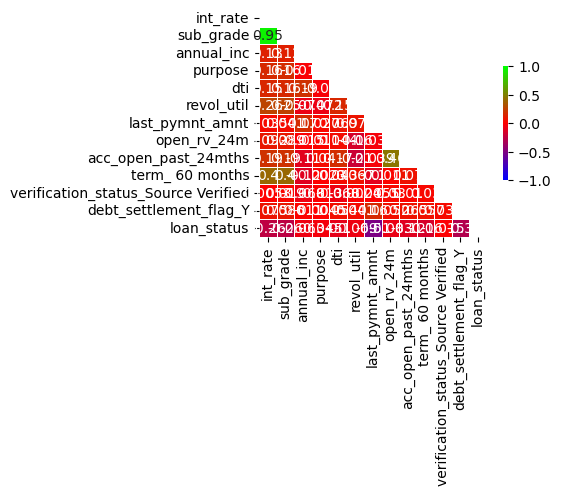

Time taken to run: 0:00:00


Training the model...
Best params for RndSearchCV:
{'solver': 'liblinear', 'penalty': 'l2', 'l1_ratio': 0.5, 'class_weight': 'balanced', 'C': 100}
Time taken to train: 0:00:03

Results on the test dataset:


Accuracy Score:

0.8140747176368376

Classification Report:

              precision    recall  f1-score   support

         0.0       0.52      0.90      0.66       229
         1.0       0.97      0.79      0.87       922

    accuracy                           0.81      1151
   macro avg       0.74      0.85      0.77      1151
weighted avg       0.88      0.81      0.83      1151


Confusion Matrix:



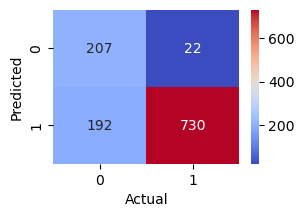


K-S Table:



,Total count,Number of bad,Number of Non-bad,bad_Rate%,Percent of bad%,Percent of Non-bad%,Cum % bad,Cum % Non-bad,ks_stats,max_ks
decile_group,,,,,,,,,,
"(0.999, 1.0]",115,115.000000,0.000000,100.000000,12.470000,0.000000,12.470000,0.000000,12.470000,
"(0.998, 0.999]",115,115.000000,0.000000,100.000000,12.470000,0.000000,24.950000,0.000000,24.950000,
"(0.997, 0.998]",115,115.000000,0.000000,100.000000,12.470000,0.000000,37.420000,0.000000,37.420000,
"(0.991, 0.997]",115,115.000000,0.000000,100.000000,12.470000,0.000000,49.890000,0.000000,49.890000,
"(0.937, 0.991]",115,115.000000,0.000000,100.000000,12.470000,0.000000,62.360000,0.000000,62.360000,
"(0.602, 0.937]",115,105.000000,10.000000,91.300000,11.390000,4.370000,73.750000,4.370000,69.390000,*****
"(0.398, 0.602]",115,82.000000,33.000000,71.300000,8.890000,14.410000,82.650000,18.780000,63.870000,
"(0.277, 0.398]",115,84.000000,31.000000,73.040000,9.110000,13.540000,91.760000,32.310000,59.440000,
"(0.118, 0.277]",115,61.000000,54.000000,53.040000,6.620000,23.580000,98.370000,55.900000,42.480000,


Time taken to run: 0:00:01

Results on the train dataset:


Accuracy Score:

0.8245004344048653

Classification Report:

              precision    recall  f1-score   support

         0.0       0.53      0.91      0.67       916
         1.0       0.97      0.80      0.88      3688

    accuracy                           0.82      4604
   macro avg       0.75      0.86      0.78      4604
weighted avg       0.89      0.82      0.84      4604


Confusion Matrix:



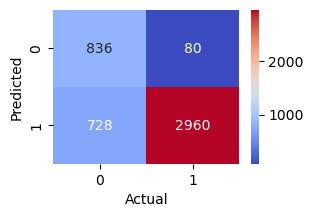


K-S Table:



,Total count,Number of bad,Number of Non-bad,bad_Rate%,Percent of bad%,Percent of Non-bad%,Cum % bad,Cum % Non-bad,ks_stats,max_ks
decile_group,,,,,,,,,,
"(0.9994, 1.0]",461,461.000000,0.000000,100.000000,12.500000,0.000000,12.500000,0.000000,12.500000,
"(0.9986, 0.9994]",460,460.000000,0.000000,100.000000,12.470000,0.000000,24.970000,0.000000,24.970000,
"(0.9973, 0.9986]",460,459.000000,1.000000,99.780000,12.450000,0.110000,37.420000,0.110000,37.310000,
"(0.9922, 0.9973]",461,461.000000,0.000000,100.000000,12.500000,0.000000,49.920000,0.110000,49.810000,
"(0.9592, 0.9922]",460,459.000000,1.000000,99.780000,12.450000,0.110000,62.360000,0.220000,62.150000,
"(0.6099, 0.9592]",460,426.000000,34.000000,92.610000,11.550000,3.710000,73.920000,3.930000,69.990000,
"(0.3962, 0.6099]",461,373.000000,88.000000,80.910000,10.110000,9.610000,84.030000,13.540000,70.490000,*****
"(0.2631, 0.3962]",460,311.000000,149.000000,67.610000,8.430000,16.270000,92.460000,29.800000,62.660000,
"(0.1016, 0.2631]",460,200.000000,260.000000,43.480000,5.420000,28.380000,97.890000,58.190000,39.700000,


Time taken to run: 0:00:02

Time taken to run the whole pipeline: 0:00:36



In [9]:
# Running the pipeline and setting the parameters for logistic regression

sp = statistical_pipeline(df_loan_m, 'loan_status', sample_size = -1, stratify = ['loan_status', 'term'])

# Put monotonic_woe = True for monotonic woe binning using scorecardpy library
# You can put a number on rfe_n_features_to_select to have that much features, otherwise it will estimate the optimal number of features by itself
# Univariate and Bivariate reports will be saved in csv files 
# VIF, ANOVA and MI are optional. You can set their respective thresholds using vif_thres, anova_thres and mi_thres respectively.
# sp.autorun(model = 'log_reg' ,SMOTE = True, monotonic_woe = False, rfe_n_features_to_select = 12, VIF = True, ANOVA = True, MI = True, test_size = 0.2, mi_thres = 0.002, display_mis = False
#           , cap_outliers = True)

sp.autorun(
        predefined_variables_for_exclusion = [],
        time_period_datasets = [],
        cols_with_missing_values_threshold = 80,
        remove_high_cardinality_cols = True,
        high_cardinality_threshold = 40,
        psi_bins = 10,
        psi_thres = 0.2,
        missing_values_fillna_kind = 'special_value',
        cap_outliers = True,
        capping_numeric_cardinality_limit = 200,
        Cramers_V = True,
        monotonic_woe = True,
        numeric_woe = True,
        VIF = False,
        ANOVA = False, 
        MI = False,
        anova_thres = 0.05,
        mi_thres = 0.02,
        iv_thres = 0.02,
        iv_bins = 10,
        display_ivs = False,
        vif_thres = 7,
        display_mis = False,
        display_vifs = False,
        corr_thres = 0.5,
        cramers_v_thres = 0.5,
        dummy_thres = 3,
        rfe_n_features_to_select = 12,
        RFE = True,
        test_size = 0.2,
        train_test_stratify = ['loan_status'],
        test_dataset = None,
        test_dataset_sample_size = -1,
        test_dataset_stratify = [],
        SMOTE = True,
        model = 'log_reg',
        reports_filepath = '',
        unique_id_cols = [],
        normalization = None
)

Accuracy Score:

0.7661028730305839

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.71      0.83     13789
           1       0.46      0.97      0.63      3475

    accuracy                           0.77     17264
   macro avg       0.73      0.84      0.73     17264
weighted avg       0.88      0.77      0.79     17264


Confusion Matrix:



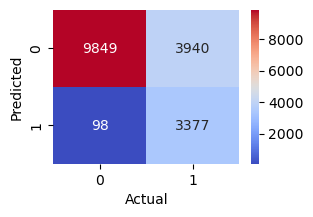


K-S Table:



,Total count,Number of bad,Number of Non-bad,bad_Rate%,Percent of bad%,Percent of Non-bad%,Cum % bad,Cum % Non-bad,ks_stats,max_ks
decile_group,,,,,,,,,,
"(0.81, 0.936]",1727,1383,344,80.080000,39.800000,2.490000,39.800000,2.490000,37.300000,
"(0.737, 0.81]",1726,905,821,52.430000,26.040000,5.950000,65.840000,8.450000,57.390000,
"(0.669, 0.737]",1726,606,1120,35.110000,17.440000,8.120000,83.280000,16.570000,66.710000,
"(0.556, 0.669]",1727,428,1299,24.780000,12.320000,9.420000,95.600000,25.990000,69.610000,*****
"(0.154, 0.556]",1726,146,1580,8.460000,4.200000,11.460000,99.800000,37.450000,62.350000,
"(0.0138, 0.154]",1726,7,1719,0.410000,0.200000,12.470000,100.000000,49.920000,50.080000,
"(0.00774, 0.0138]",1727,0,1727,0.000000,0.000000,12.520000,100.000000,62.440000,37.560000,
"(0.00512, 0.00774]",1726,0,1726,0.000000,0.000000,12.520000,100.000000,74.960000,25.040000,
"(0.00326, 0.00512]",1726,0,1726,0.000000,0.000000,12.520000,100.000000,87.480000,12.520000,


Time taken to test: 0:00:38



In [14]:
# Testing the logistic regression pipeline on the test data we had
y_pred, y_proba = sp.predict(df_loan_m, dataname = 'pdv')

These categorical features were found to be inconsistent betweent the datasets:
[]
Count:0

Time taken to run: 0:00:00

These columns were manually reduced:
[]
Count:0

Time taken to run: 0:00:00

Creating Univariate Distribution Templates...
Time taken to run: 0:00:07

These columns had high amount of missing values hence dropped:
['id', 'member_id', 'url', 'desc', 'mths_since_last_record', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_proj

None



Information of the current data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34613 entries, 0 to 34612
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   int_rate                             34613 non-null  float64
 1   annual_inc                           34613 non-null  float64
 2   loan_status                          34613 non-null  float64
 3   dti                                  34613 non-null  float64
 4   inq_last_6mths                       34613 non-null  int64  
 5   revol_util                           34613 non-null  float64
 6   last_pymnt_amnt                      34613 non-null  float64
 7   all_util                             34613 non-null  float64
 8   acc_open_past_24mths                 34613 non-null  float64
 9   mths_since_recent_inq                34613 non-null  float64
 10  term_ 60 months                      34613 non-null  float

None


Correlation matrix for the current dataset:



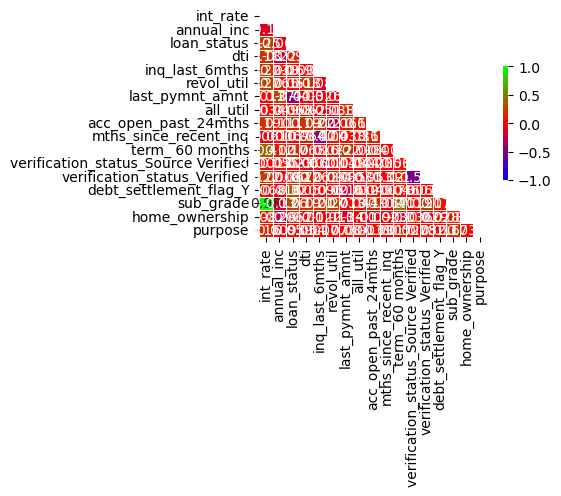

Time taken to run: 0:00:00


Training the model...
Best params for RndSearchCV:
{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 50, 'min_child_weight': 0.1, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Time taken to train: 0:00:32

Results on the test dataset:


Accuracy Score:

0.9058211757908421

Classification Report:

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      5538
         1.0       0.83      0.66      0.74      1385

    accuracy                           0.91      6923
   macro avg       0.88      0.81      0.84      6923
weighted avg       0.90      0.91      0.90      6923


Confusion Matrix:



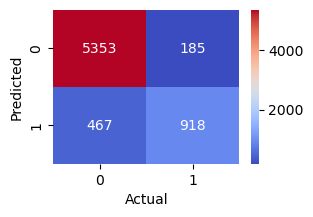


K-S Table:



,Total count,Number of bad,Number of Non-bad,bad_Rate%,Percent of bad%,Percent of Non-bad%,Cum % bad,Cum % Non-bad,ks_stats,max_ks
decile_group,,,,,,,,,,
"(0.75, 0.993]",693,638.000000,55.000000,92.060000,46.060000,0.990000,46.060000,0.990000,45.070000,
"(0.382, 0.75]",692,397.000000,295.000000,57.370000,28.660000,5.330000,74.730000,6.320000,68.410000,
"(0.215, 0.382]",692,212.000000,480.000000,30.640000,15.310000,8.670000,90.040000,14.990000,75.050000,*****
"(0.101, 0.215]",692,106.000000,586.000000,15.320000,7.650000,10.580000,97.690000,25.570000,72.120000,
"(0.0163, 0.101]",692,29.000000,663.000000,4.190000,2.090000,11.970000,99.780000,37.540000,62.240000,
"(0.0115, 0.0163]",693,1.000000,692.000000,0.140000,0.070000,12.500000,99.860000,50.040000,49.820000,
"(0.00973, 0.0115]",692,2.000000,690.000000,0.290000,0.140000,12.460000,100.000000,62.500000,37.500000,
"(0.00836, 0.00973]",692,0.000000,692.000000,0.000000,0.000000,12.500000,100.000000,74.990000,25.010000,
"(0.00693, 0.00836]",692,0.000000,692.000000,0.000000,0.000000,12.500000,100.000000,87.490000,12.510000,


Time taken to run: 0:00:06

Results on the train dataset:


Accuracy Score:

0.913289996388588

Classification Report:

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     22148
         1.0       0.85      0.69      0.76      5542

    accuracy                           0.91     27690
   macro avg       0.89      0.83      0.85     27690
weighted avg       0.91      0.91      0.91     27690


Confusion Matrix:



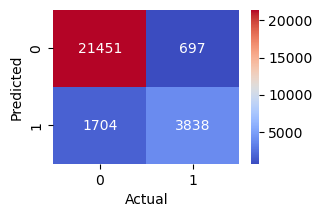


K-S Table:



,Total count,Number of bad,Number of Non-bad,bad_Rate%,Percent of bad%,Percent of Non-bad%,Cum % bad,Cum % Non-bad,ks_stats,max_ks
decile_group,,,,,,,,,,
"(0.75, 0.994]",2769,2616.000000,153.000000,94.470000,47.200000,0.690000,47.200000,0.690000,46.510000,
"(0.392, 0.75]",2769,1701.000000,1068.000000,61.430000,30.690000,4.820000,77.900000,5.510000,72.380000,
"(0.218, 0.392]",2769,824.000000,1945.000000,29.760000,14.870000,8.780000,92.760000,14.290000,78.470000,*****
"(0.0952, 0.218]",2769,346.000000,2423.000000,12.500000,6.240000,10.940000,99.010000,25.230000,73.770000,
"(0.0159, 0.0952]",2769,51.000000,2718.000000,1.840000,0.920000,12.270000,99.930000,37.510000,62.420000,
"(0.0114, 0.0159]",2769,2.000000,2767.000000,0.070000,0.040000,12.490000,99.960000,50.000000,49.960000,
"(0.00967, 0.0114]",2769,1.000000,2768.000000,0.040000,0.020000,12.500000,99.980000,62.500000,37.480000,
"(0.00841, 0.00967]",2769,1.000000,2768.000000,0.040000,0.020000,12.500000,100.000000,75.000000,25.000000,
"(0.007, 0.00841]",2769,0.000000,2769.000000,0.000000,0.000000,12.500000,100.000000,87.500000,12.500000,


Time taken to run: 0:00:23

Time taken to run the whole pipeline: 0:03:21



In [20]:
# Running the pipeline and setting the parameters for tree based models

sp = statistical_pipeline(df_loan, 'loan_status', sample_size = -1, stratify = ['loan_status', 'term'])

# Put monotonic_woe = True for monotonic woe binning using scorecardpy library
# You can put a number on rfe_n_features_to_select to have that much features, otherwise it will estimate the optimal number of features by itself
# Univariate and Bivariate reports will be saved in csv files 
# VIF, ANOVA and MI are optional. You can set their respective thresholds using vif_thres, anova_thres and mi_thres respectively.
# sp.autorun(model = 'log_reg' ,SMOTE = True, monotonic_woe = False, rfe_n_features_to_select = 12, VIF = True, ANOVA = True, MI = True, test_size = 0.2, mi_thres = 0.002, display_mis = False
#           , cap_outliers = True)

sp.autorun(
        predefined_variables_for_exclusion = [],
        time_period_datasets = [],
        cols_with_missing_values_threshold = 80,
        remove_high_cardinality_cols = True,
        high_cardinality_threshold = 40,
        psi_bins = 10,
        psi_thres = 0.2,
        missing_values_fillna_kind = 'special_value',
        cap_outliers = True,
        capping_numeric_cardinality_limit = 200,
        Cramers_V = True,
        monotonic_woe = False,
        numeric_woe = False,
        VIF = False,
        ANOVA = False, 
        MI = False,
        anova_thres = 0.05,
        mi_thres = 0.02,
        iv_thres = 0.02,
        iv_bins = 10,
        display_ivs = False,
        vif_thres = 7,
        display_mis = False,
        display_vifs = False,
        corr_thres = 0.5,
        cramers_v_thres = 0.5,
        dummy_thres = 3,
        rfe_n_features_to_select = 12,
        RFE = False,
        test_size = 0.2,
        train_test_stratify = ['loan_status'],
        test_dataset = None,
        test_dataset_sample_size = -1,
        test_dataset_stratify = [],
        SMOTE = True,
        model = 'lgbm',
        reports_filepath = '',
        unique_id_cols = [],
        normalization = None
)

Accuracy Score:

0.9102177942539388

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     13789
           1       0.84      0.68      0.75      3475

    accuracy                           0.91     17264
   macro avg       0.88      0.83      0.85     17264
weighted avg       0.91      0.91      0.91     17264


Confusion Matrix:



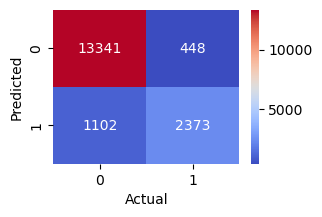


K-S Table:



,Total count,Number of bad,Number of Non-bad,bad_Rate%,Percent of bad%,Percent of Non-bad%,Cum % bad,Cum % Non-bad,ks_stats,max_ks
decile_group,,,,,,,,,,
"(0.75, 0.994]",1727,1606,121,92.990000,46.220000,0.880000,46.220000,0.880000,45.340000,
"(0.389, 0.75]",1726,1067,659,61.820000,30.710000,4.780000,76.920000,5.660000,71.260000,
"(0.217, 0.389]",1726,535,1191,31.000000,15.400000,8.640000,92.320000,14.290000,78.020000,*****
"(0.0995, 0.217]",1727,227,1500,13.140000,6.530000,10.880000,98.850000,25.170000,73.680000,
"(0.0165, 0.0995]",1726,38,1688,2.200000,1.090000,12.240000,99.940000,37.410000,62.530000,
"(0.0115, 0.0165]",1726,2,1724,0.120000,0.060000,12.500000,100.000000,49.920000,50.080000,
"(0.00971, 0.0115]",1727,0,1727,0.000000,0.000000,12.520000,100.000000,62.440000,37.560000,
"(0.00841, 0.00971]",1726,0,1726,0.000000,0.000000,12.520000,100.000000,74.960000,25.040000,
"(0.00703, 0.00841]",1726,0,1726,0.000000,0.000000,12.520000,100.000000,87.480000,12.520000,


Time taken to test: 0:00:47



In [21]:
y_pred, y_proba = sp.predict(df_loan_m, dataname = 'pdv')

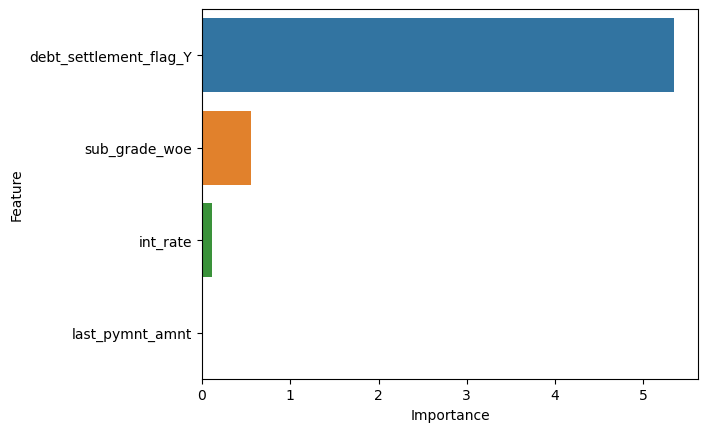

In [103]:
coef = sp.model.named_steps['classifier'].coef_

importances = np.mean(np.abs(coef), axis=0)
importances = pd.DataFrame({'Feature': sp.X.columns, 'Importance': importances})
importances = importances.sort_values(by = 'Importance', ascending = False)
importances
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have a DataFrame df with columns 'A' and 'B'
sns.barplot(x='Importance', y='Feature', data=importances, orient='h')

plt.show()

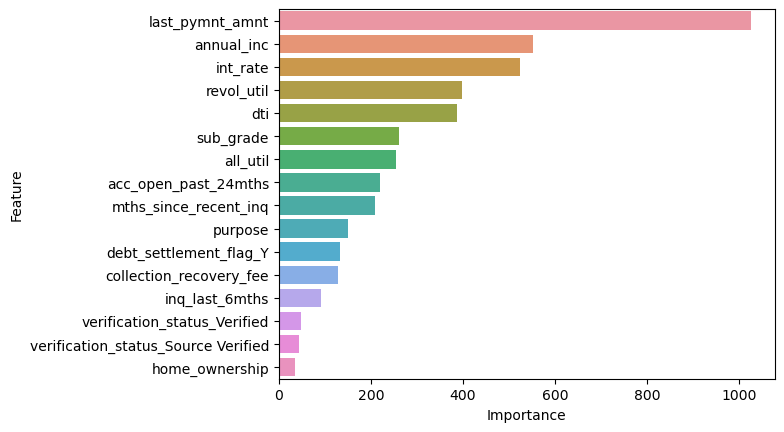

In [85]:
importances = sp.model.named_steps['classifier'].feature_importances_.copy()
importances = pd.DataFrame({'Feature': sp.X.columns, 'Importance': importances})
importances = importances.sort_values(by = 'Importance', ascending = False)
importances
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have a DataFrame df with columns 'A' and 'B'
sns.barplot(x='Importance', y='Feature', data=importances, orient='h')

plt.show()

In [8]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)

OSError: [Errno 16] Device or resource busy: '/kaggle/working'